# Modelo TFT

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import TFT
from neuralforecast.losses.pytorch import MAE
from sklearn.metrics import mean_squared_error
from utilsforecast.plotting import plot_series
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Establecer el estilo de las gráficas
plt.style.use('seaborn-v0_8')

2025-03-30 19:48:17,325	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.6.5 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-03-30 19:48:17,526	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.6.5 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Carga y Preprocesado del Dataset

In [2]:
tickets = ["AAPL", "AMZN", "TSLA", "GOOGL", "MSFT"]
dfs = []
i = 0
for ticket in tickets:
    df = pd.read_csv(f'../Data/Global_Data_{ticket}.csv', parse_dates=['Date'])
    df['unique_id'] = i  # Asigna un identificador numérico a cada ticket
    i += 1
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

# Definir las características (variables financieras y de sentimiento)
features = ['Open', 'High', 'Low', 'Close', 'Volume', 
            'SMA_50', 'SMA_200', 'RSI', 'MACD', 'MACD_signal', 
            'avg_sentiment', 'weighted_sentiment', 'sentiment_sma_7', 
            'sentiment_sma_14', 'tweet_count']

# Filtrar el DataFrame y ordenarlo
df_filt = df[['Date', 'unique_id'] + features]
df_filt = df_filt.sort_values(by=['unique_id', 'Date'])

# Reindexar para que cada 'unique_id' tenga un índice diario completo
dfs_with_full_dates = []
for unique_id in df_filt['unique_id'].unique():
    df_ticker = df_filt[df_filt['unique_id'] == unique_id]
    full_idx_ticker = pd.date_range(start=df_ticker['Date'].min(), end=df_ticker['Date'].max(), freq='D')
    df_ticker_reindexed = df_ticker.set_index('Date').reindex(full_idx_ticker).reset_index()
    df_ticker_reindexed.rename(columns={'index': 'Date'}, inplace=True)
    df_ticker_reindexed['unique_id'] = unique_id
    dfs_with_full_dates.append(df_ticker_reindexed)
df_filt_full = pd.concat(dfs_with_full_dates, ignore_index=True)

# Imputar valores faltantes por interpolación lineal
df_filt_full[features] = df_filt_full[features].interpolate(method='linear')

## Creación de Nuevas Variables

In [3]:
# Variables exógenas futuras
lag = 14
for feat in ['Open', 'High', 'Low', 'Volume', 'Close', 'SMA_50', 'SMA_200', 'RSI', 'MACD']:
    df_filt_full[f"{feat}_lag{lag}"] = df_filt_full.groupby('unique_id')[feat].shift(lag)
for feat in ['weighted_sentiment', 'tweet_count', 'sentiment_sma_7', 'sentiment_sma_14']:
    df_filt_full[f"{feat}_lag{lag}"] = df_filt_full.groupby('unique_id')[feat].shift(lag)

# Variables exógenas históricas
df_filt_full['Close_SMA_10_hist'] = df_filt_full.groupby('unique_id')['Close'].transform(lambda x: x.rolling(10).mean().shift(14))
df_filt_full['Close_SMA_30_hist'] = df_filt_full.groupby('unique_id')['Close'].transform(lambda x: x.rolling(30).mean().shift(14))

df_filt_full['Close_momentum_hist'] = df_filt_full['Close'].pct_change(periods=10).shift(14)
df_filt_full['Close_volatility_20_hist'] = df_filt_full.groupby('unique_id')['Close'].transform(lambda x: x.rolling(20).std().shift(14))

## Definición del Dataset Final y de las Variables Exógenas

In [4]:
# Rellenar los valores faltantes con 0
df_filt_full = df_filt_full.fillna(0)

# Renombrar columnas para compatibilidad con Nixtla
df_final = df_filt_full.rename(columns={'Date': 'ds', 'Close': 'y'})

# Varibales exógenas futuras
futr_exog_list = [
    'Open_lag14', 'High_lag14', 'Low_lag14', 'Volume_lag14', 'Close_lag14',
    'SMA_50_lag14', 'SMA_200_lag14', 'RSI_lag14', 'MACD_lag14',
    'weighted_sentiment_lag14', 'sentiment_sma_7_lag14', 'sentiment_sma_14_lag14', 'tweet_count_lag14',
]

# Variables exógenas históricas
hist_exog_list = [
    'Close_SMA_10_hist', 'Close_SMA_30_hist', 'Close_momentum_hist', 'Close_volatility_20_hist'
]

df_final

,ds,unique_id,Open,High,Low,y,Volume,SMA_50,SMA_200,RSI,...,RSI_lag14,MACD_lag14,weighted_sentiment_lag14,tweet_count_lag14,sentiment_sma_7_lag14,sentiment_sma_14_lag14,Close_SMA_10_hist,Close_SMA_30_hist,Close_momentum_hist,Close_volatility_20_hist
0,2016-10-19,0,-1.923882,-1.940571,-1.987976,-1.923895,-0.843739,-2.227854,-2.383641,0.439562,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2016-10-20,0,-1.925562,-1.951164,-1.916395,-1.934864,-0.541287,-2.222643,-2.380764,0.292853,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2016-10-21,0,-1.921433,-1.948655,-1.911656,-1.933176,-0.552137,-2.219828,-2.379146,0.306937,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2016-10-22,0,-1.917303,-1.946146,-1.906917,-1.931489,-0.562988,-2.217013,-2.377527,0.321021,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2016-10-23,0,-1.913173,-1.943637,-1.902178,-1.929801,-0.573839,-2.214198,-2.375909,0.335104,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5840,2019-12-27,4,2.078001,2.059150,2.101008,2.097364,-0.755330,1.872373,1.860070,1.736185,...,0.889952,0.918937,-0.945404,-0.138762,-0.109147,-0.406261,1.779864,1.758800,0.128969,0.045961
5841,2019-12-28,4,2.060497,2.052411,2.081831,2.091483,-0.814606,1.877174,1.863253,1.648411,...,1.070523,0.983453,-0.680183,-0.282788,-0.434407,-0.310079,1.793531,1.767345,0.078534,0.049675
5842,2019-12-29,4,2.042992,2.045672,2.062653,2.085602,-0.873882,1.881974,1.866436,1.560638,...,1.251094,1.047970,-0.414962,-0.426814,-0.759666,-0.213897,1.810240,1.774347,0.096209,0.054654
5843,2019-12-30,4,2.025487,2.038933,2.043476,2.079721,-0.933157,1.886774,1.869620,1.472865,...,1.431666,1.112487,-0.149741,-0.570840,-1.084926,-0.117715,1.826043,1.781762,0.089132,0.062528


## División el Dataset en Entrenamiento y Prueba

In [5]:
# Dividir en conjunto de entrenamiento y prueba
train = df_final[df_final['ds'] <= '2019-09-30']
test = df_final[(df_final['ds'] > '2019-09-30')].reset_index(drop=True)

print(train.shape[0])
print(test.shape[0])

5385
460


## Entrenamiento del Modelo Informer

In [6]:
# Inicializar el Modelo TFT (Temporal Fusion Transformer)
models = [
    TFT(
        h=14,
        input_size=30,
        hidden_size=64,
        dropout=0.1,
        n_head = 8,
        grn_activation='ELU',
        rnn_type="LSTM",
        n_rnn_layers=2,
        one_rnn_initial_state=False,
        futr_exog_list=futr_exog_list,
        hist_exog_list= hist_exog_list,
        loss=MAE(),
        scaler_type='robust',
        learning_rate=1e-3,
        max_steps=800,
        batch_size=128,
        step_size=1
    ),
]

# Crear el objeto NeuralForecast y ajustar el modelo
nf = NeuralForecast(
    models=models,
    freq='D'  # Frecuencia diaria
)

# Entrenar el modelo TFT
nf.fit(df=train)

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 2.3 K  | train
4 | temporal_encoder        | TemporalCovariateEncoder | 840 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 63.7 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
906 K     Trainable params
0         Non-trainable params
906 K     Total params
3.627     Tota

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=800` reached.


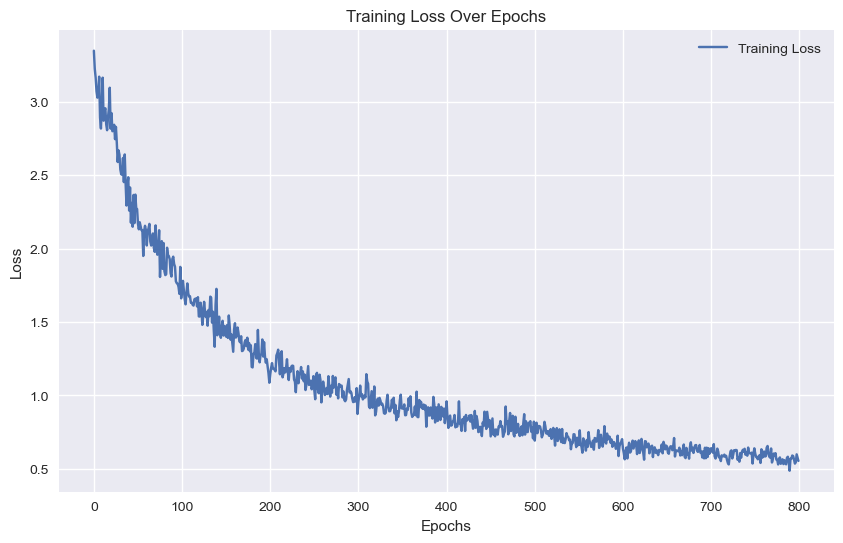

In [6]:
# Obtener el historial de pérdidas del modelo desde los resultados de entrenamiento
losses = nf.models[0].train_trajectories

# Extraer los valores de la pérdida y las épocas
epochs = [x[0] for x in losses]  # Épocas
train_loss = [x[1] for x in losses]  # Pérdidas

# Graficar las pérdidas de entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label="Training Loss")

# Añadir etiquetas y título
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()

# Mostrar la gráfica
plt.show()

## Validación del Modelo

In [7]:
cv_result = nf.cross_validation(df=train, n_windows=4, step_size=14)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 2.3 K  | train
4 | temporal_encoder        | TemporalCovariateEncoder | 840 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 63.7 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
906 K     Trainable params
0         Non-trainable params
906 K     Total params
3.627     Total estimated mo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=800` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

#### Resultados Validación Cruzada para una Empresa

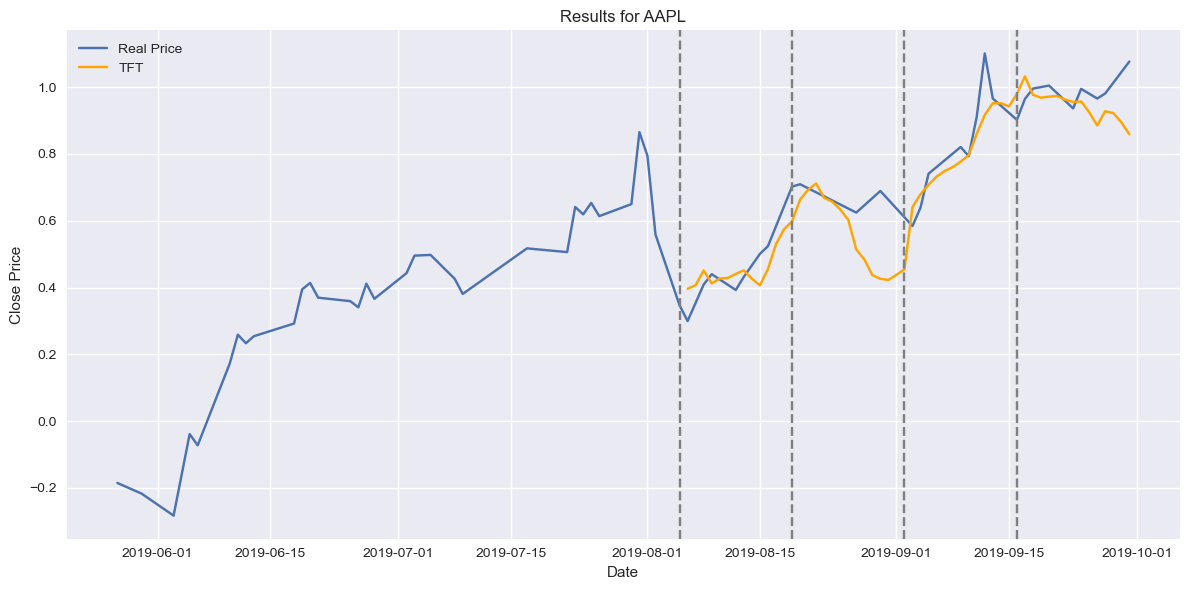

In [ ]:
# Crear la figura y los ejes para el gráfico
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Seleccionar el conjunto de datos de entrenamiento para una empresa
ticker = 0  # ID de AAPL
Y = train[train['unique_id'] == ticker][950:]  # Filtrar los datos a partir de un índice específico
cv_res = cv_result[cv_result['unique_id'] == ticker]  # Resultados de la validación cruzada para AAPL

# Obtener los puntos de corte únicos de la validación cruzada
cutoffs = cv_res['cutoff'].unique()

# Graficar los datos reales y predicciones
ax.plot(Y['ds'], Y['y'], label="Real Price ")
ax.plot(cv_res['ds'], cv_res['Informer'], label='Informer', color='orange')

# Añadir las líneas de corte
for cutoff in cutoffs:
    ax.axvline(x=cutoff, color='grey', ls='--')

# Configurar el gráfico
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.set_title('Results for TSLA')
ax.legend()

# Ajustar el diseño y mostrar la figura
plt.tight_layout()
plt.show()

#### Resultados Validación Cruzada de las Empresas

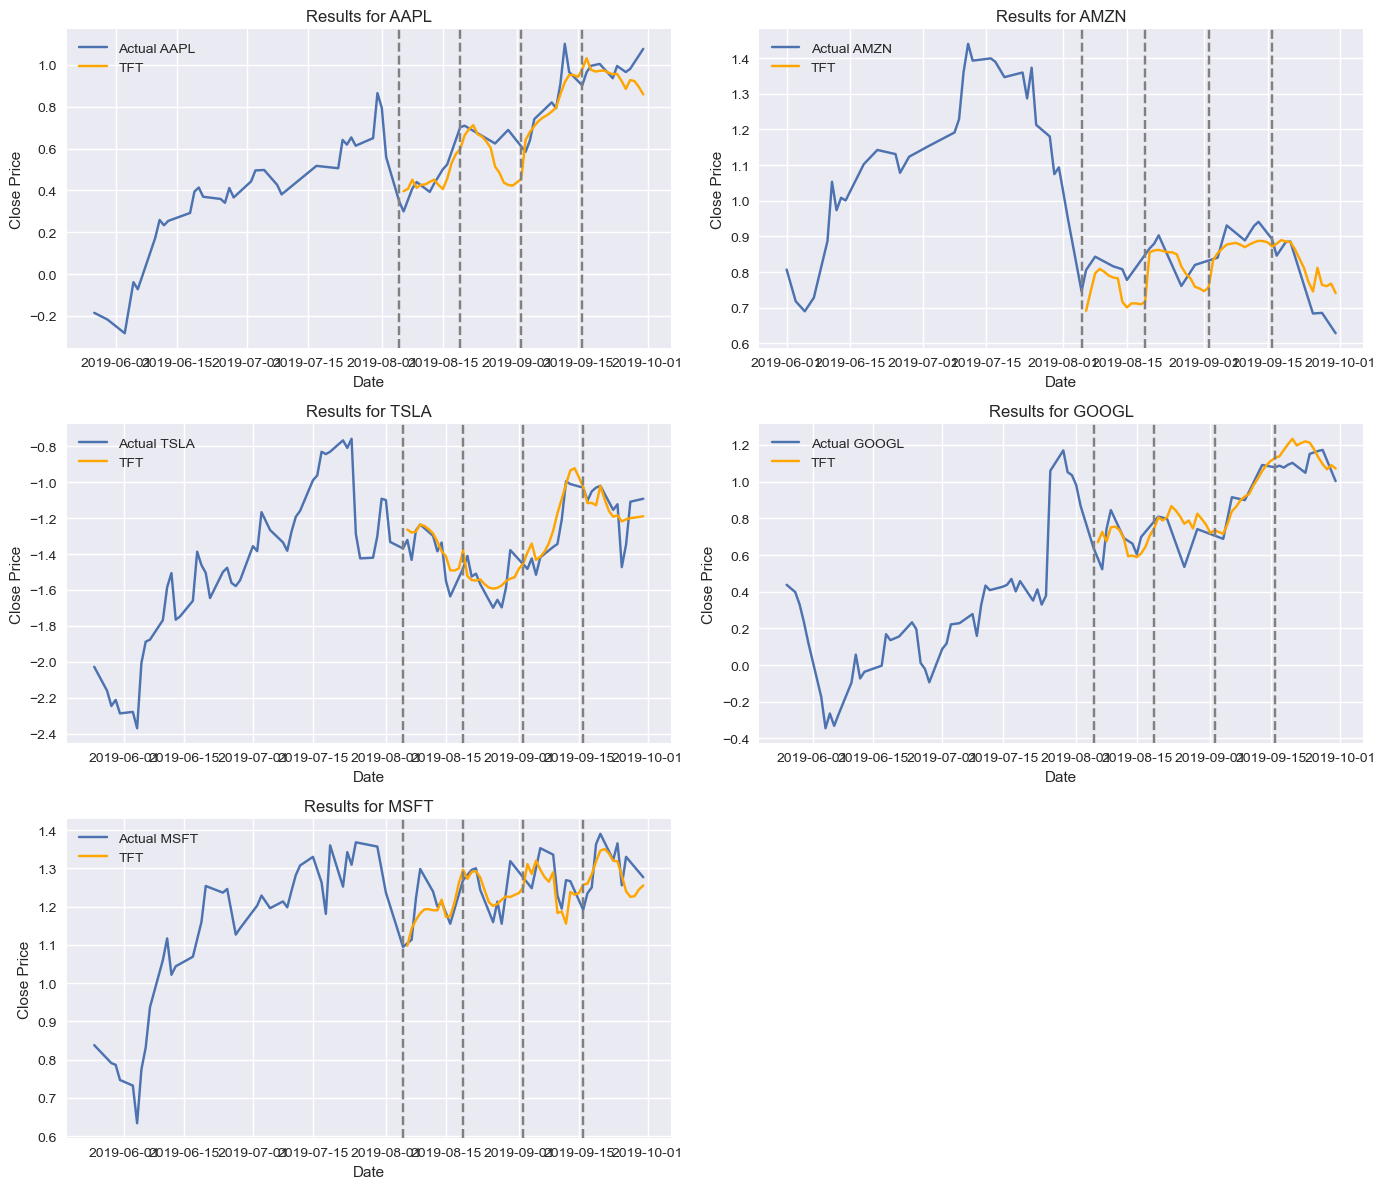

In [ ]:
# Definir la figura con 3 filas y 2 columnas
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()  # Aplanar la matriz de ejes para facilitar la iteración

# Iterar sobre las empresas y graficarlas en sus respectivos subgráficos
for i, company in enumerate(tickets):
    ax = axes[i]  # Seleccionar el eje correspondiente

    # Filtrar los datos de entrenamiento y los resultados de la validación cruzada para cada empresa
    Y_company = train[train['unique_id'] == range(0, 5)[i]][1000:]
    cv_res_company = cv_result[cv_result['unique_id'] == range(0, 5)[i]]

    # Obtener los puntos de corte únicos
    cutoffs = cv_res_company['cutoff'].unique()

    # Graficar los datos reales y predicciones
    ax.plot(Y_company['ds'], Y_company['y'], label=f"Actual {company}")
    ax.plot(cv_res_company['ds'], cv_res_company['TFT'], label='TFT', color='orange')

    # Añadir las líneas de corte
    for cutoff in cutoffs:
        ax.axvline(x=cutoff, color='grey', ls='--')

    # Configurar el gráfico
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')
    ax.set_title(f'Results for {company}')
    ax.legend()

# Dejar el último cuadro vacío
axes[-1].axis('off')

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()

# Mostrar la figura con todas las subgráficas
plt.show()

#### Resultados de las Métricas de Validación Cruzada

In [8]:
# Calcular las métricas de cada empresa
metrics = []

empresa_dict = {0: 'AAPL', 1: 'AMZN', 2: 'TSLA', 3: 'GOOGL', 4: 'MSFT'}

# Agrupar por empresa (unique_id)
for empresa_id, group in cv_result.groupby('unique_id'):
    y_true = group['y']
    y_pred = group['TFT']
    
    # Calcular MAE, RMSE, MAPE para cada empresa
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = np.sqrt(mape)
    
    # Guardar los resultados
    metrics.append({
        'Empresa': empresa_dict[empresa_id],
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'SMAPE': smape,
    })

# Crear un DataFrame con las métricas
metrics_df = pd.DataFrame(metrics)

# Mostrar las métricas
metrics_df

,Empresa,MAE,MSE,RMSE,MAPE,SMAPE
0,AAPL,0.066639,0.008775,0.093672,9.803353,3.131031
1,AMZN,0.049725,0.003700,0.060829,6.297254,2.509433
2,TSLA,0.070238,0.007624,0.087316,5.252414,2.291815
3,GOOGL,0.067122,0.007813,0.088392,8.778971,2.962933
4,MSFT,0.039630,0.002412,0.049113,3.111282,1.763883


## Evaluación del Modelo

In [12]:
# Realizar predicciones utilizando el conjunto de prueba y las variables exógenas futuras
forecasts = nf.predict(futr_df=test)
forecasts

c:\Users\pmyoe\anaconda3\Lib\site-packages\neuralforecast\core.py:904: UserWarning: Dropped 390 unused rows from `futr_df`.
  warnings.warn(f"Dropped {dropped_rows:,} unused rows from `futr_df`.")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

,unique_id,ds,TFT
0,0,2019-10-01,1.094464
1,0,2019-10-02,1.071843
2,0,2019-10-03,1.068529
3,0,2019-10-04,1.052018
4,0,2019-10-05,1.061773
...,...,...,...
65,4,2019-10-10,1.301113
66,4,2019-10-11,1.300040
67,4,2019-10-12,1.303163
68,4,2019-10-13,1.313421


#### Resultados Evaluación para una Empresa

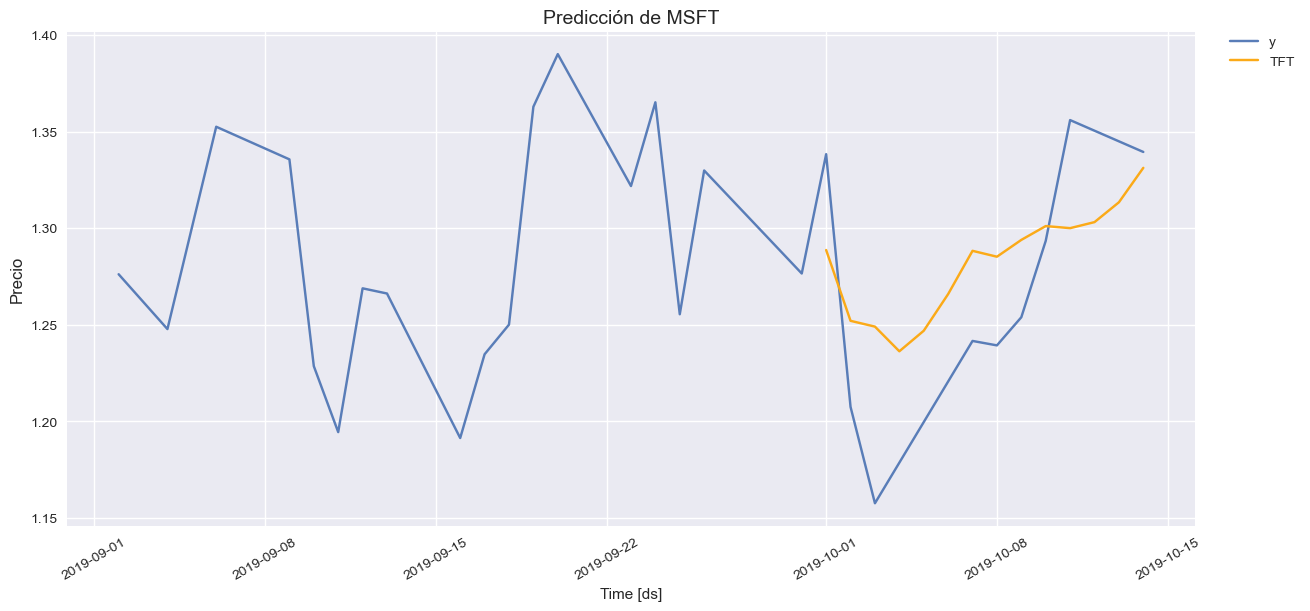

In [ ]:
# Filtrar los datos solo para AAPL y en el rango de fechas especificado
ticker = 4  # ID de MSFT
df_filtered = df_final[(df_final['unique_id'] == ticker) &
                       (df_final['ds'] > '2019-08-01') & (df_final['ds'] <= '2019-10-14')]

forecasts_filtered = forecasts[(forecasts['unique_id'] == 4)]

# Graficar con plot_series de Nixtla
fig = plot_series(
    df_filtered,              
    forecasts_df=forecasts_filtered,
    engine='matplotlib',  
    id_col='unique_id',  
    time_col='ds',  
    target_col='y',  
    plot_random=False,  
    real_color='#597db8',
    forecast_color='#fbaa18'
)

# Acceder al eje y modificar su título
ax = fig.axes[0]
ax.set_title("Results for MSFT", fontsize=14)
ax.set_ylabel('Price', fontsize=12)

fig

#### Resultados Evaluación de las Empresas

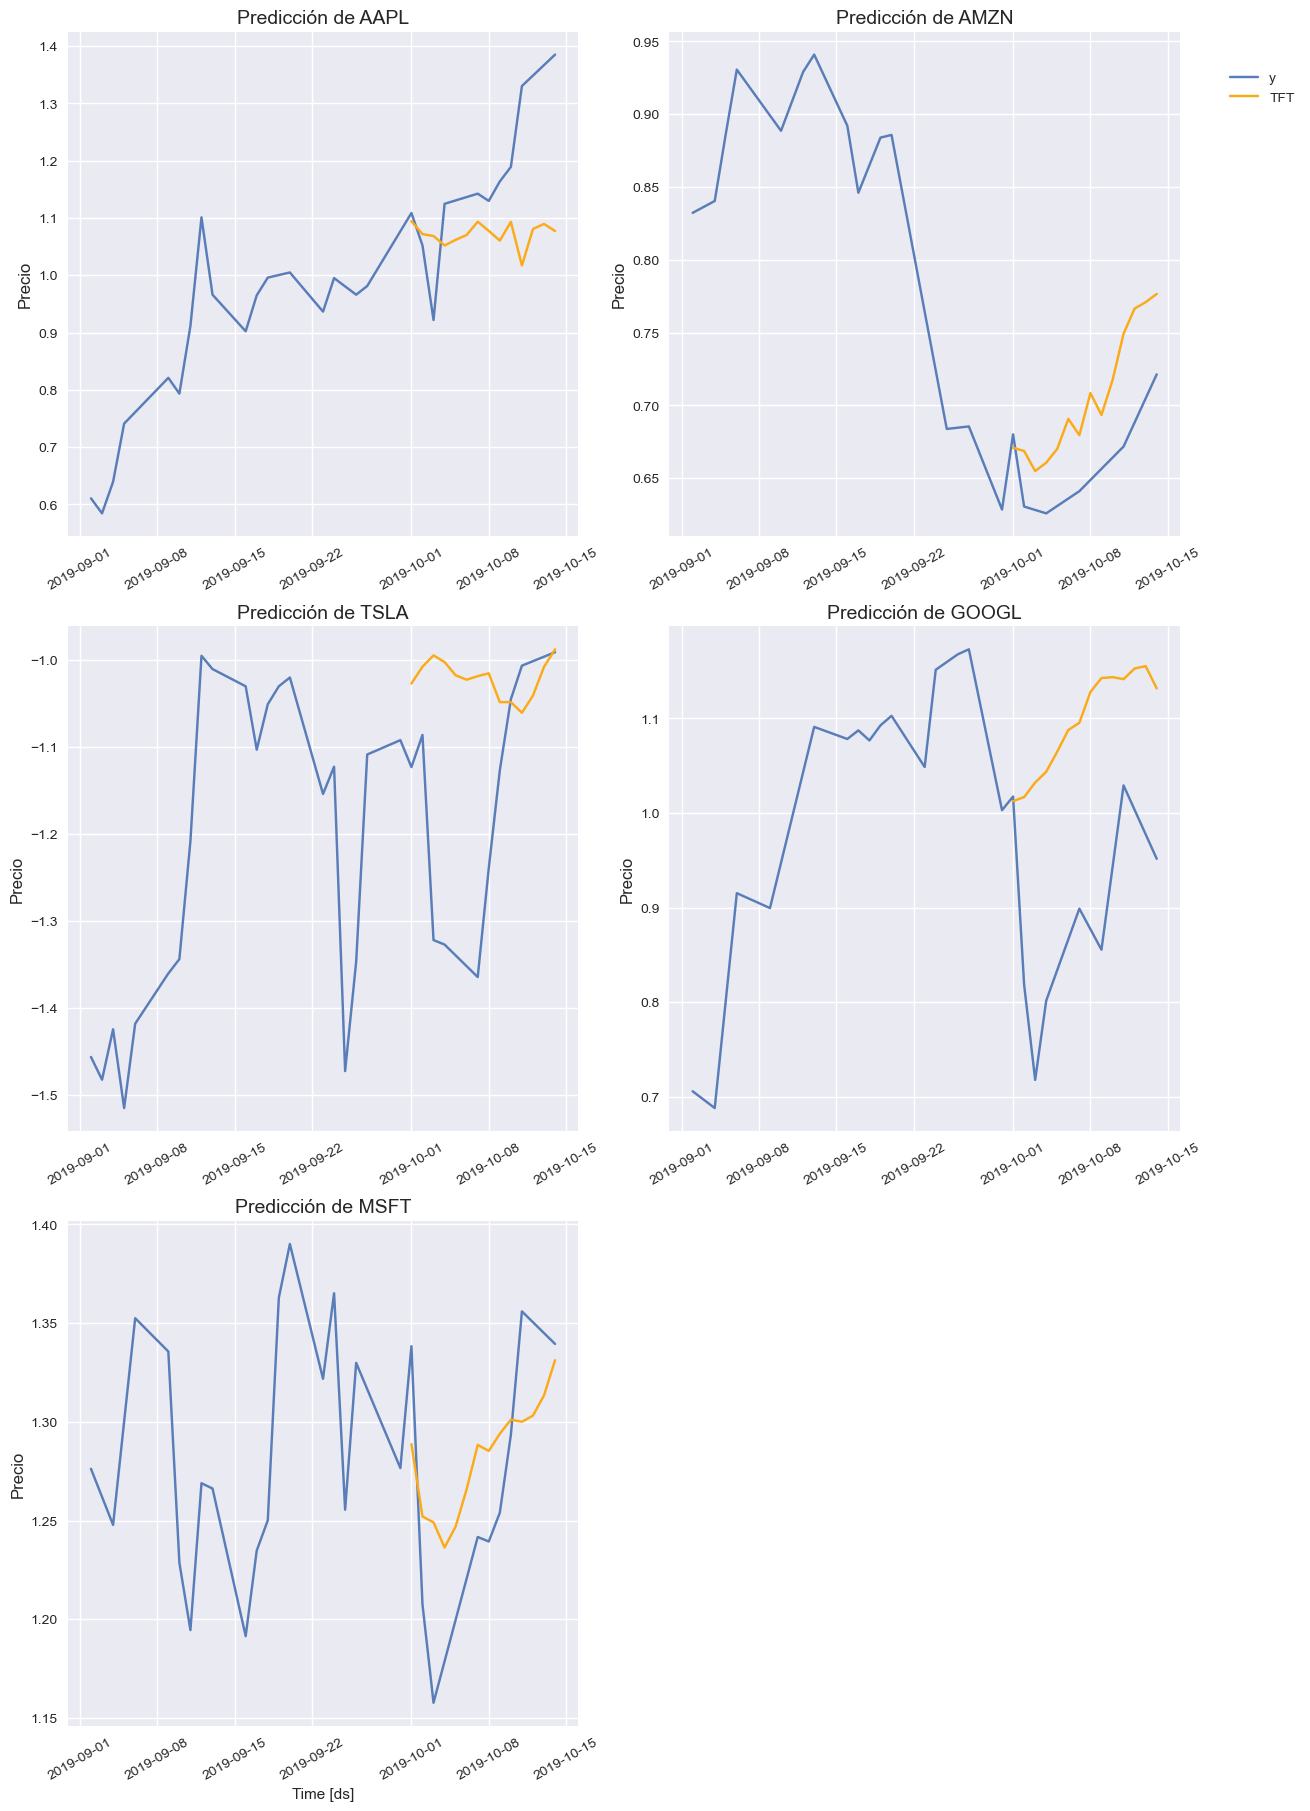

In [ ]:
# Filtrar los datos para el rango de fechas especificado
df_filtered = df_final[(df_final['ds'] > '2019-09-01') & (df_final['ds'] <= '2019-10-14')]

# Graficar con plot_series (la función retorna una figura, no un par de valores)
fig = plot_series(
    df_filtered,
    forecasts_df=forecasts,
    engine='matplotlib',
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    plot_random=False,
    real_color = '#597db8',
    forecast_color = '#fbaa18'
)

# Diccionario que mapea unique_id con nombres de empresas
empresa_dict = {0: 'AAPL', 1: 'AMZN', 2: 'TSLA', 3: 'GOOGL', 4: 'MSFT'}

# Acceder a los ejes y añadir títulos
for ax, unique_id in zip(fig.axes, forecasts['unique_id'].unique()):
    # Obtener el nombre de la empresa desde el diccionario
    nombre_empresa = empresa_dict.get(unique_id, "Empresa Desconocida")
    
    ax.set_title(f"Predicción de {nombre_empresa}", fontsize=14)
    ax.set_ylabel('Precio', fontsize=12)


fig

#### Resultados de las Métricas de  Evaluación

In [ ]:
# Renombrar la predicción del modelo
forecasts.rename(columns={'TFT_pred': 'TFT'}, inplace=True)

# Filtrar el conjunto de prueba dentro del rango de fechas deseado
test = test.loc[(test['ds'] >= '2019-10-01') & (test['ds'] <= '2019-10-14')]

# Fusionar predicciones con el conjunto de prueba
merged_df = test.merge(forecasts, on=['ds', 'unique_id'], how='left')

# Lista para almacenar métricas
metrics = []

# Calcular métricas por empresa
for empresa_id, group in merged_df.groupby('unique_id'):
    y_true, y_pred = group['y'], group['TFT']
    
    # Filtrar valores NaN
    mask = ~(y_true.isna() | y_pred.isna())
    y_true, y_pred = y_true[mask], y_pred[mask]
    
    if y_true.empty:
        continue

    # Calcular métricas
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = np.sqrt(mape)

    # Guardar métricas
    metrics.append({
        'EMPRESA': empresa_dict.get(empresa_id, empresa_id),
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'SMAPE': smape,
    })

# Crear DataFrame de métricas y convertir columnas a mayúsculas
metrics_df = pd.DataFrame(metrics)
metrics_df.columns = metrics_df.columns.str.upper()

# Mostrar el resultado final
metrics_df

,EMPRESA,MAE,MSE,RMSE,MAPE,SMAPE,R2
0,AAPL,0.132498,0.028791,0.169679,10.657965,3.264654,-0.769992
1,AMZN,0.047748,0.002629,0.051275,7.204753,2.684167,-2.044737
2,TSLA,0.160041,0.044432,0.210788,12.508713,3.536766,-1.096010
3,GOOGL,0.197602,0.044443,0.210814,22.865421,4.781780,-4.706738
4,MSFT,0.044210,0.002341,0.048385,3.547081,1.883370,0.484078
